In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import featureman.gen_data as man
from sklearn.cluster import SpectralClustering
import pickle
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
sae_dict = torch.load("sae_model_small_batch_2025-08-07_00-27-27.pth", map_location=device)
sae = man.BatchedSAE_Updated(input_dim=512, n_models=5, width_ratio=4).to(device)
sae.load_state_dict(sae_dict)

<All keys matched successfully>

In [17]:
decoder = sae.W_d[3]

#decoder normalize
decoder = decoder / decoder.norm(dim=1, keepdim=True)

all_sims = decoder @ decoder.T

all_sims.shape

torch.Size([2048, 2048])

In [18]:
all_sims.fill_diagonal_(0)  # Set diagonal to zero
#normalize all_sims
all_sims = torch.clamp(all_sims, -1, 1)
all_sims = 1 - torch.arccos(all_sims) / np.pi
all_sims = all_sims.detach().cpu().numpy()
def spectral_cluster_sims(all_sims, n_clusters=1000):
    sc = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=42)
    labels = sc.fit_predict(all_sims).tolist()
    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(labels):
        clusters[label].append(i)
    pickle.dump(
        clusters,
        open(f"sae_clusters_small_batch_8.pkl", "wb"),
    )
sc = spectral_cluster_sims(all_sims, n_clusters=8)

In [5]:
# load the clusters
with open("sae_clusters.pkl", "rb") as f:
    clusters = pickle.load(f)


In [58]:
clusters = [c for c in clusters if len(c) > 1]  # Filter out clusters with only one element
clusters = sorted(clusters, key=lambda x: len(x), reverse=True)  # Sort by size

In [77]:
#import pca
from sklearn.decomposition import PCA
from tqdm import tqdm

pcas = []
for c in tqdm(clusters):
    pca = PCA()
    pcas.append((pca, pca.fit_transform(sae.W_d[3][c].detach().cpu().numpy())))

100%|██████████| 174/174 [00:00<00:00, 944.25it/s]


In [78]:
pcas[0][1].shape

(57, 57)

In [79]:
pcas[0][0].explained_variance_ratio_

array([1.7448337e-01, 1.3375360e-01, 9.6738666e-02, 8.5351765e-02,
       7.3082745e-02, 6.2653996e-02, 5.3083010e-02, 5.2034721e-02,
       4.2067107e-02, 3.6328785e-02, 3.0998006e-02, 2.2692736e-02,
       1.8644122e-02, 1.6736468e-02, 1.0533987e-02, 7.8946939e-03,
       6.4180503e-03, 5.5147507e-03, 5.0032702e-03, 4.3984419e-03,
       3.7641160e-03, 3.5136188e-03, 3.3056403e-03, 3.2865559e-03,
       3.0295018e-03, 2.9403132e-03, 2.8305615e-03, 2.7262385e-03,
       2.5980864e-03, 2.4019086e-03, 2.3391331e-03, 2.1775095e-03,
       2.0705592e-03, 1.8350205e-03, 1.7819669e-03, 1.6511349e-03,
       1.5744403e-03, 1.4820332e-03, 1.3974226e-03, 1.3754187e-03,
       1.2972037e-03, 1.2183036e-03, 1.2096387e-03, 1.1112216e-03,
       9.8320376e-04, 9.4012113e-04, 9.2512346e-04, 9.0955955e-04,
       8.1842195e-04, 7.9692900e-04, 6.7325099e-04, 6.3619466e-04,
       5.7888590e-04, 4.9979030e-04, 4.8341541e-04, 4.2536549e-04,
       1.0854636e-14], dtype=float32)

# what to do next
- decoder/dict_atoms -> sae_hidden x mlp_dim
- relu_acts -> sae_hidden
- out -> mlp_dim

- concat(samples X filtered_sae_hidden) x mlp_dim
- einop('s f m -> (s f) m')
- PCA of that stuff

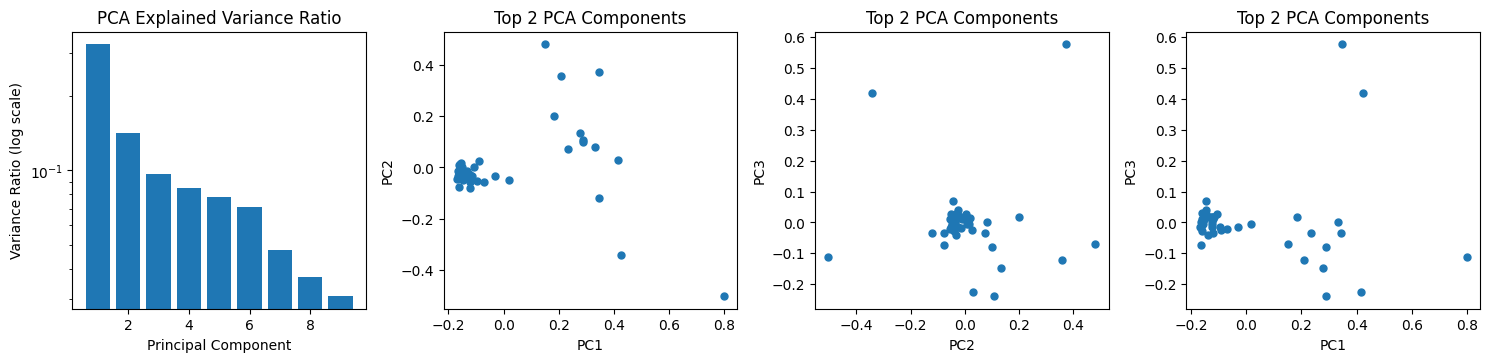

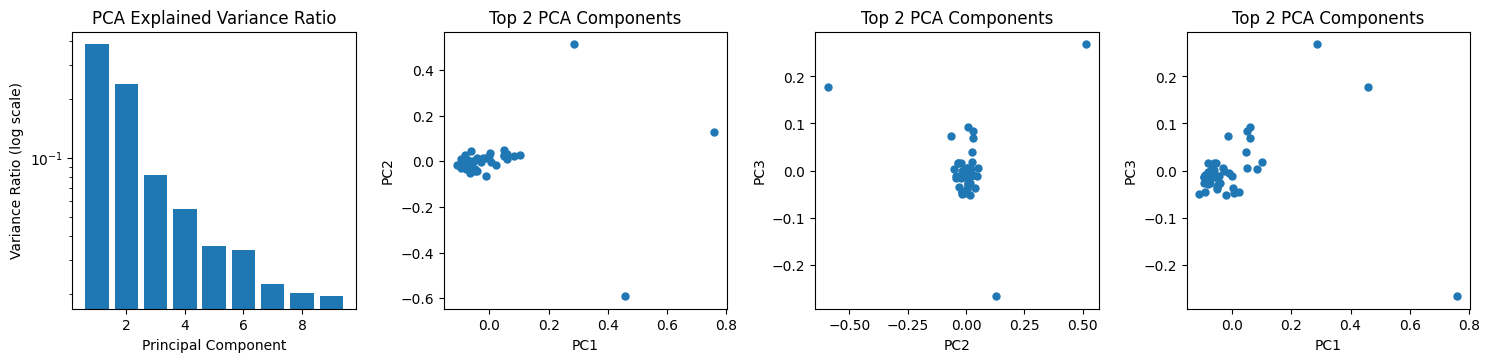

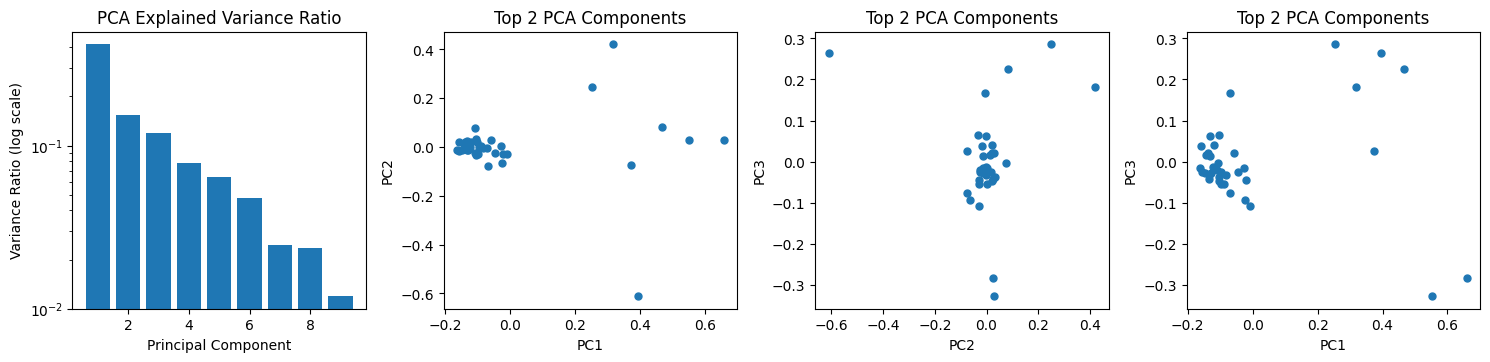

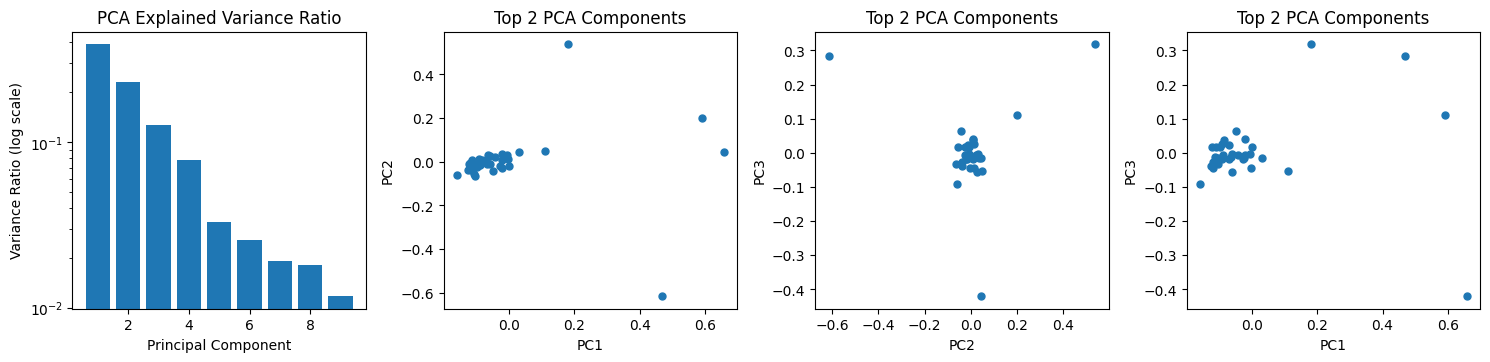

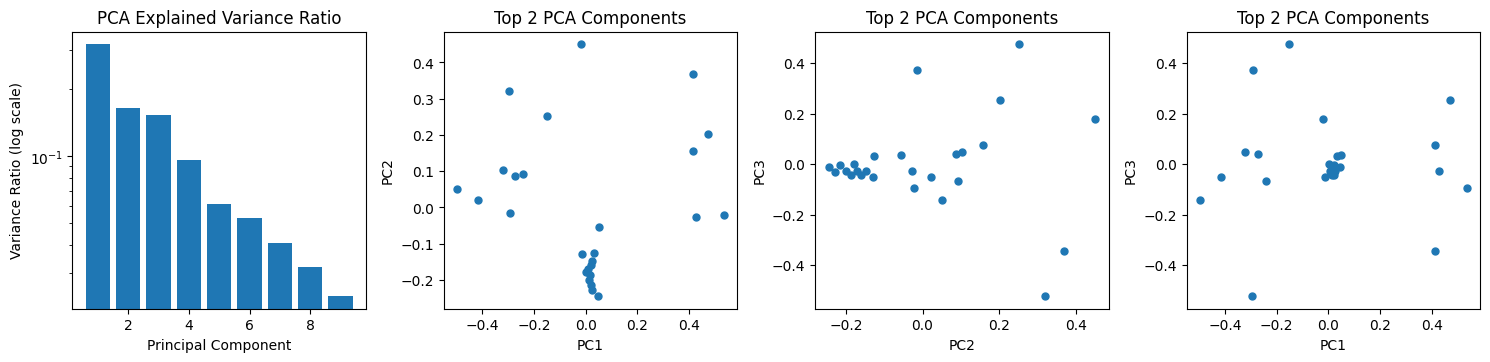

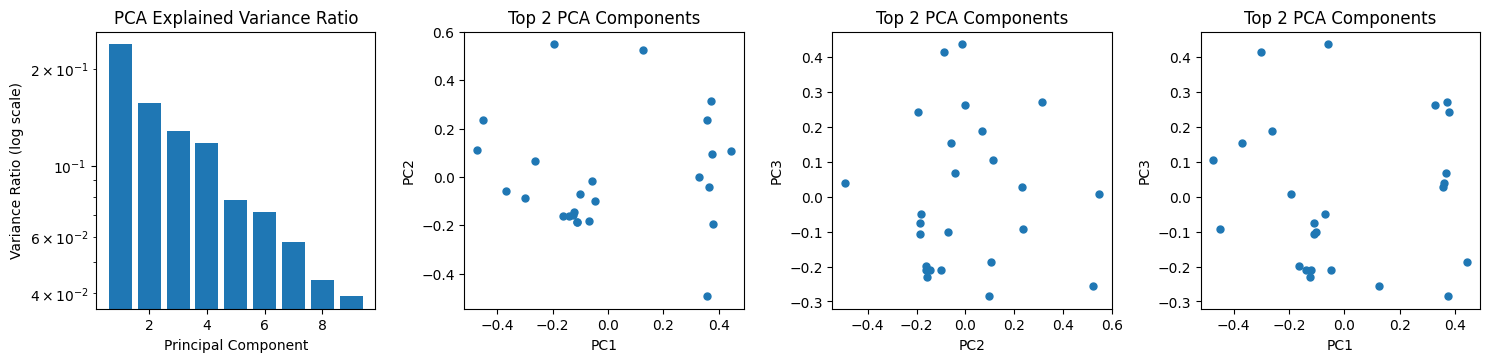

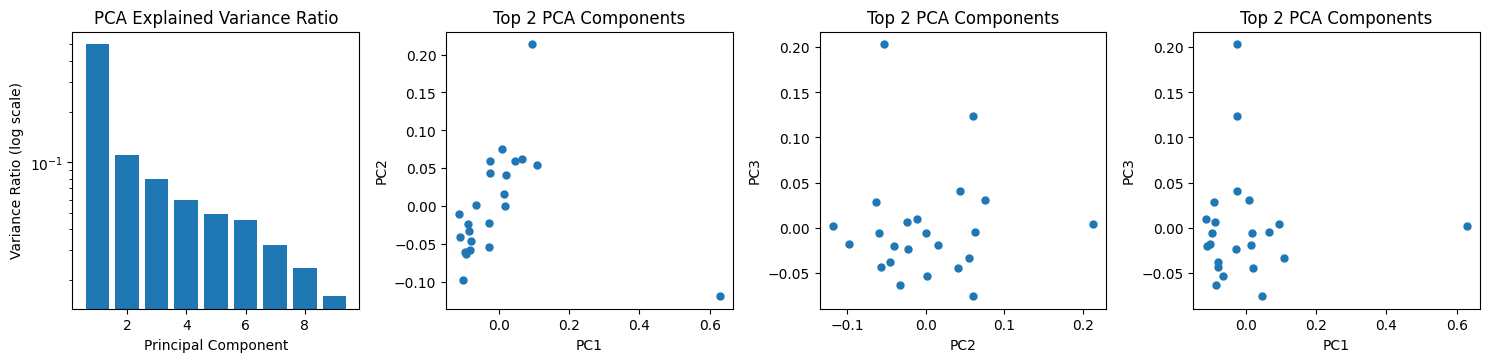

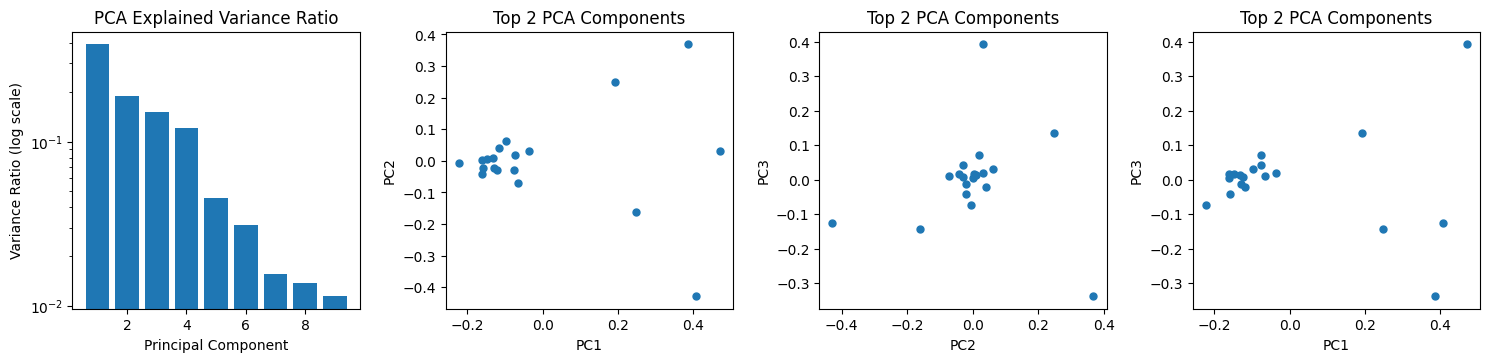

In [80]:
for i in range(2, 10):
    fig = plt.figure(figsize=(15, 10))

    ax1 = plt.subplot(3, 4, 1)
    ax1.bar(range(1,10), pcas[i][0].explained_variance_ratio_[:9])
    ax1.set_yscale('log')
    ax1.set_title('PCA Explained Variance Ratio')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Variance Ratio (log scale)')

    ax2 = plt.subplot(3, 4, 2)
    ax2.plot(pcas[i][1][:, 0], pcas[i][1][:, 1], 'o', markersize=5)
    ax2.set_title('Top 2 PCA Components')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')

    ax3 = plt.subplot(3, 4, 3)
    ax3.plot(pcas[i][1][:, 1], pcas[i][1][:, 2], 'o', markersize=5)
    ax3.set_title('Top 2 PCA Components')
    ax3.set_xlabel('PC2')
    ax3.set_ylabel('PC3')

    ax4 = plt.subplot(3, 4, 4)
    ax4.plot(pcas[i][1][:, 0], pcas[i][1][:, 2], 'o', markersize=5)
    ax4.set_title('Top 2 PCA Components')
    ax4.set_xlabel('PC1')
    ax4.set_ylabel('PC3')

    plt.tight_layout()

plt.show()